In [2]:
%load_ext autoreload 
%autoreload 2


import pandas as pd
import glob
import nltk
from transformers import pipeline
from transformers import AutoModelForSequenceClassification, TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import expit
import os
# import os, json, openai, warnings, random
import os, json, warnings, random
import numpy as np
import pandas as pd
from IPython.display import Image, display


from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import networkx
from networkx.drawing.nx_agraph import graphviz_layout 
import pylab

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Called  https://mastodon.social/api/v2/instance
instance_stats = {
  "domain": "mastodon.social",
  "title": "Mastodon",
  "version": "4.1.2+nightly-20230627",
  "source_url": "https://github.com/mastodon/mastodon",
  "description": "The original server operated by the Mastodon gGmbH non-profit",
  "usage": {
    "users": {
      "active_month": 221664
    }
  }
}

In [5]:
# s3://ml-team-pocket/social_hackweek_2023/topic_discoveries/
# I used replied_toots_2023_05_27.tar.gz and untar into data folder.
# data_path = "../../data"
data_path = "../../data/jag_data"
base_path = "{}/replied_toots_2023_05_27".format(data_path)
datasets = glob.glob("{}/toots_mastodon*.parquet".format(base_path))
toots_df = pd.concat([pd.read_parquet(data) for data in datasets], axis=0).reset_index(drop=True)
print(len(toots_df))
toots_df = toots_df.drop_duplicates(subset=['id'])
display(toots_df.describe())

467840


,replies_count,reblogs_count,favourites_count,created_at_ts
count,467840.000000,467840.000000,467840.000000,4.678400e+05
mean,0.314434,0.892179,0.586215,1.685347e+09
std,1.182122,9.693559,6.947695,1.648873e+06
min,0.000000,0.000000,0.000000,1.072769e+09
25%,0.000000,0.000000,0.000000,1.685286e+09
50%,0.000000,0.000000,0.000000,1.685354e+09
75%,0.000000,0.000000,0.000000,1.685416e+09
max,156.000000,1934.000000,1114.000000,2.147484e+09


In [7]:
toots_df.head().T

,0,1,2,3,4
id,110447382829980018,110447382871190341,110447382941236108,110447382661880747,110447382940075628
created_at,2023-05-28T17:00:21.000Z,2023-05-28T17:00:39.000Z,2023-05-28T17:00:51.000Z,2023-05-28T17:00:53.000Z,2023-05-28T17:00:58.000Z
in_reply_to_id,None,None,None,None,None
in_reply_to_account_id,None,None,None,None,None
sensitive,False,False,False,False,False
spoiler_text,,,,,
visibility,public,public,public,public,public
language,en,en,en,en,en
uri,https://sportsbots.xyz/users/UGAfootballLive/s...,https://sportsbots.xyz/users/thelionswire/stat...,https://sportsbots.xyz/users/PitcherList/statu...,https://sportsbots.xyz/users/Marlins/statuses/...,https://sportsbots.xyz/users/RadiNabulsi/statu...
url,https://twitter.com/UGAfootballLive/status/166...,https://twitter.com/thelionswire/status/166286...,https://twitter.com/PitcherList/status/1662866...,https://twitter.com/Marlins/status/16628665441...,https://twitter.com/RadiNabulsi/status/1662866...


In [9]:
base_path

'../../data/jag_data/replied_toots_2023_05_27'

In [8]:
datasets = glob.glob("{}/status_mastodon*.parquet".format(base_path))
statuses_df = pd.concat([pd.read_parquet(data) for data in datasets], axis=0).reset_index(drop=True)
statuses_df = statuses_df[(statuses_df['content'].apply(len) < 256) & (statuses_df['language'] == 'en') & (statuses_df['content'] != '' )]
statuses_df = statuses_df.drop_duplicates(subset=['id'])
len(statuses_df)

17143

In [11]:
statuses_df.head().T

,5,28,29,30,32
id,110461932325769439,110459078623134695,110459114331962627,110459594796328418,110460425624094355
created_at,2023-05-31T06:42:04.000Z,2023-05-30T18:36:20.750Z,2023-05-30T18:45:25.000Z,2023-05-30T20:47:36.929Z,2023-05-31T00:18:54.354Z
in_reply_to_id,110457770232945617,110458869437383298,110459078623134695,110459114331962627,110458869437383298
in_reply_to_account_id,109307846083092090,109287781845114155,108196672360465948,109287781845114155,109287781845114155
sensitive,False,False,False,False,False
spoiler_text,,,,,
visibility,public,public,public,public,public
language,en,en,en,en,en
uri,https://mstdn.social/users/dfrancis/statuses/1...,https://mastodon.social/users/macario_moreno/s...,https://mastodon.gamedev.place/users/djlink/st...,https://mastodon.social/users/macario_moreno/s...,https://mastodon.social/users/dbinkowski/statu...
url,https://mstdn.social/@dfrancis/110461932281763073,https://mastodon.social/@macario_moreno/110459...,https://mastodon.gamedev.place/@djlink/1104591...,https://mastodon.social/@macario_moreno/110459...,https://mastodon.social/@dbinkowski/1104604256...


In [13]:
# statuses_df['account'].values[0]

0      380030
1       62466
2       14322
3        5127
4        2291
        ...  
113         1
44          1
64          1
93          1
98          1
Name: replies_count, Length: 65, dtype: int64

0      368258
1       54135
2       16826
3        8225
4        4811
        ...  
197         1
817         1
135         1
541         1
514         1
Name: reblogs_count, Length: 303, dtype: int64

0      402831
1       34190
2       11173
3        5415
4        3232
        ...  
168         1
289         1
206         1
323         1
180         1
Name: favourites_count, Length: 244, dtype: int64

,replies_count,reblogs_count,favourites_count,created_at_ts
count,467840.000000,467840.000000,467840.000000,4.678400e+05
mean,0.314434,0.892179,0.586215,1.685347e+09
std,1.182122,9.693559,6.947695,1.648873e+06
min,0.000000,0.000000,0.000000,1.072769e+09
25%,0.000000,0.000000,0.000000,1.685286e+09
50%,0.000000,0.000000,0.000000,1.685354e+09
75%,0.000000,0.000000,0.000000,1.685416e+09
max,156.000000,1934.000000,1114.000000,2.147484e+09


,replies_count,reblogs_count,favourites_count,created_at_ts
count,87810.000000,87810.000000,87810.000000,8.781000e+04
mean,1.675265,3.231910,2.128026,1.685354e+09
std,2.272778,22.000494,15.705106,1.561296e+06
min,1.000000,0.000000,0.000000,1.683740e+09
25%,1.000000,0.000000,0.000000,1.685287e+09
50%,1.000000,0.000000,0.000000,1.685352e+09
75%,2.000000,2.000000,1.000000,1.685410e+09
max,156.000000,1934.000000,1114.000000,2.147484e+09


<Axes: xlabel='replies_count', ylabel='Count'>

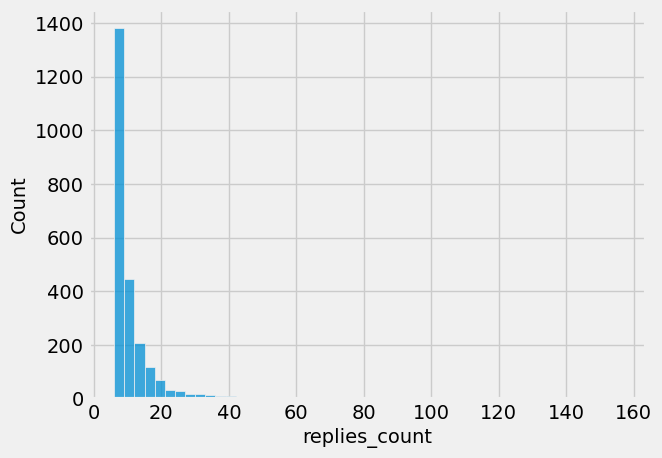

In [14]:
accts = toots_df['account'].apply(lambda acc: acc['acct'])
display(toots_df['replies_count'].value_counts(), toots_df['reblogs_count'].value_counts(), toots_df['favourites_count'].value_counts())

replies_only_df = toots_df.loc[toots_df['replies_count'] > 0]
# out of 167K, only 20K have replies, and 99% are less then 1.
# sns.histplot(data=replies_only_df, y="replies_count")

display(toots_df.describe())
display(replies_only_df.describe())
replies_only_df_pruned = toots_df.loc[toots_df['replies_count'] > 5]
sns.histplot(data=replies_only_df_pruned, x="replies_count", binwidth=3)



In [15]:
from collections import defaultdict
import networkx as nx

def create_graph_from_status(_statuses_df, min_degree=0, max_degree=2**32):
    # Lets collate things by the influencer nodes 
    influencers = defaultdict(set)
    
    for k, status in _statuses_df.iterrows():
        if status['parent_account_id'] == None: # just a very few this is not filled incorrectly i believe
            continue
        if status['parent_account_id'] == status['account']['id']: #self
            continue
        influencers[status['parent_account_id']].add(status['account']['id'])
    
    # pruning
    to_delete = []
    for influencer, followers in influencers.items():
        if min_degree and len(followers) < min_degree or len(followers) > max_degree:
            to_delete.append(influencer)
        
    for infl in to_delete:
        del influencers[infl]
    
    G=nx.Graph()
    for dest, edges in influencers.items():
        for src in edges:
            G.add_edge(src, dest)
            
    return G

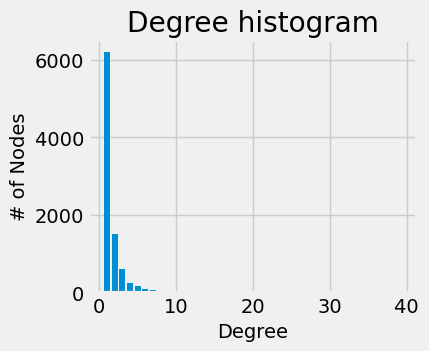

In [29]:
# Distribution of degree
status_gph = create_graph_from_status(statuses_df)
deg=nx.degree(status_gph)

degree_sequence = sorted((d for n, d in status_gph.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

In [28]:
# degree_sequence

In [20]:
len(status_gph.nodes()), len(status_gph.edges())

(9112, 8324)

In [30]:
# sorted(status_gph.degree(), key=lambda g: -g[1])

In [31]:
# Stats
import math

total_toots = len(toots_df)
replies_count_df = toots_df.loc[toots_df['replies_count'] > 0]
with_replies_pct = int(len(replies_count_df)/total_toots * 100)
median = replies_count_df['replies_count'].median()

print("""
Total Toots: {}
With Replies: {}%
Median Replies: {}""".format(total_toots, with_replies_pct, median))

median_degree = degree_sequence[int(len(degree_sequence) / 2)]
avg_degree = sum(degree_sequence)/len(degree_sequence)

total_threads = (statuses_df['parent_account_id'] != statuses_df['parent_account_id'].shift(axis=0)).sum(axis=0)
# closeness = nx.closeness_centrality(G) # This is slow
# Average Closness {} hops - need to convert to hops - otherwise doesn't make sense
cluster_coefficient = nx.average_clustering(status_gph)


print("""
Total Threads: {} 
Median Degree: {} connn/pp
Avg Degree: {}
Cluster Coefficient {}%""".format(total_threads, median_degree,  avg_degree, round(cluster_coefficient * 100, 2)))



Total Toots: 467840
With Replies: 18%
Median Replies: 1.0

Total Threads: 7412 
Median Degree: 1 connn/pp
Avg Degree: 1.8270412642669007
Cluster Coefficient 0.9%


In [54]:
def draw_kamada(G):
    nodes = G.nodes()
    degree = G.degree()
    colors = [degree[n] for n in nodes]
    pos = nx.kamada_kawai_layout(G)
#     pos = nx.spring_layout(G, k = 0.2)
    cmap = plt.cm.viridis_r
    cmap = plt.cm.Greys

    vmin = min(colors)
    vmax = max(colors)

    fig = plt.figure(figsize = (15,9), dpi=100)

#     nx.draw(G,pos,alpha = 0.8, nodelist = nodes, node_color = 'w', node_size = 10, with_labels= False,font_size = 6, width = 0.2, cmap = cmap, edge_color ='yellow')
    nx.draw_networkx(G,pos,alpha = 0.8, nodelist = nodes, node_color = 'b', node_size = 10, with_labels= False,font_size = 6, width = 0.2, cmap = cmap, edge_color ='green')
    fig.set_facecolor('#0B243B')

    plt.legend()
    plt.show()


def analyze_centrality_1(G, fast=False):

    degrees_df = pd.DataFrame.from_dict({node: val for node, val in nx.degree(status_gph)}, orient='index')
    degrees_df.index.names=['ID']
    degrees_df.columns = ['degree']
    degrees_df.reset_index(level=0, inplace=True)
    analyse = degrees_df

    # Betweenness centrality 
    if not fast:
        bet_cen = nx.betweenness_centrality(G)
        df_bet_cen = pd.DataFrame.from_dict(bet_cen, orient='index')
        df_bet_cen.columns = ['betweenness_centrality']
        df_bet_cen.index.names = ['ID']
        df_bet_cen.reset_index(level=0, inplace=True)
        analyse= pd.merge(analyse, df_bet_cen, on = ['ID'])

    # Clustering coefficient 
    clust_coefficients = nx.clustering(G)
    df_clust = pd.DataFrame.from_dict(clust_coefficients, orient='index')
    df_clust.columns = ['clust_coefficient']
    df_clust.index.names = ['ID']
    df_clust.reset_index(level=0, inplace=True)
    analyse= pd.merge(analyse, df_clust, on = ['ID'])

    # Closeness centrality 
    if not fast:
        clo_cen = nx.closeness_centrality(G)
        df_clo = pd.DataFrame.from_dict(clo_cen, orient='index')
        df_clo.columns = ['closeness_centrality']
        df_clo.index.names = ['ID']
        df_clo.reset_index(level=0, inplace=True)
        analyse= pd.merge(analyse, df_clo, on = ['ID'])

    # Eigenvector centrality
    #eig_cen = nx.eigenvector_centrality(G)
    #eig_cen = nx.katz_centrality(G)
    eig_cen = nx.eigenvector_centrality_numpy(G)
    df_eig = pd.DataFrame.from_dict(eig_cen, orient='index')
    df_eig.columns = ['eigenvector_centrality']
    df_eig.index.names = ['ID']
    df_eig.reset_index(level=0, inplace=True)
    analyse= pd.merge(analyse, df_eig, on = ['ID'])
    return analyse

In [55]:
data_path

'../../data/jag_data'

In [56]:
# Sort betweeness and degree.  A node can have a lot of connection, but influence various by WHO you are connected to.
# Downloaded centrality_15K.parquet from se
should_regenerate = False
if should_regenerate:
    status_gph = create_graph_from_status(statuses_df, False)
    centrality = analyze_centrality_1(status_gph)
#     centrality.to_parquet("{}/results/centrality_15K.parquet".format(data_path))
    centrality.to_parquet("{}/results/centrality_15K.parquet".format('../../data/'))
else:
    centrality = pd.read_parquet("{}/results/centrality_15K.parquet".format('../../data/'))

print('Total Results {}'.format(len(status_gph)))
median_degree = centrality['degree']
print('Top 25 Sorted by Betweeness')
display(centrality.sort_values('betweenness_centrality', ascending=False).head(25))

print('Top 25 Sorted by  Degree')
display(centrality.sort_values('degree', ascending=False).head(50))


# Note to lookup ID - we need to use the `/api/v1/accounts` and look up the URL

Total Results 9112
Top 25 Sorted by Betweeness


,ID,degree,betweenness_centrality,clust_coefficient,closeness_centrality,eigenvector_centrality
1141,109831834621020128,61,0.034024,0.002186,0.138705,0.055001
412,108397114514160252,42,0.022833,0.002323,0.138227,0.049875
148,110402486412729575,48,0.022172,0.018617,0.132961,0.317085
514,109241099508979589,48,0.020495,0.017730,0.139254,0.029840
720,109299200705402066,45,0.018338,0.000000,0.132717,0.007955
1191,109378965434815822,33,0.017915,0.015152,0.131063,0.019718
145,109830706741689904,58,0.017095,0.022989,0.130391,0.401511
1544,109377522556951154,39,0.016416,0.001350,0.128841,0.003609
1914,109950709120207992,26,0.016286,0.012308,0.136841,0.014577
517,110073878958872277,36,0.015023,0.007937,0.137181,0.019059


Top 25 Sorted by  Degree


,ID,degree,betweenness_centrality,clust_coefficient,closeness_centrality,eigenvector_centrality
1141,109831834621020128,61,0.034024,0.002186,0.138705,0.055001
145,109830706741689904,58,0.017095,0.022989,0.130391,0.401511
1618,38659,50,0.013996,0.000000,0.132007,0.076307
514,109241099508979589,48,0.020495,0.017730,0.139254,0.029840
2613,109297938816143758,48,0.009713,0.001773,0.126577,0.007934
148,110402486412729575,48,0.022172,0.018617,0.132961,0.317085
720,109299200705402066,45,0.018338,0.000000,0.132717,0.007955
562,958614,45,0.014907,0.001010,0.134411,0.022969
6901,108193163229606399,44,0.013628,0.003171,0.131998,0.014831
585,11307,44,0.013106,0.002114,0.125494,0.015167


In [57]:
def get_graph_from_user(user_id, degrees_to_search = 2):
    _connector_df = statuses_df
    _connector_nodes = _connector_df.loc[_connector_df['parent_account_id'] == user_id].copy()
    _connector_nodes['degree'] = 1
    for deg in range(0, degrees_to_search):
        fofs_ids = _connector_nodes['account'].apply(lambda acc: acc['id']).unique()
        fofs_nodes = _connector_df.loc[_connector_df['parent_account_id'].isin(fofs_ids)].copy()
        fofs_nodes['degree'] = deg + 2
        _connector_nodes = pd.concat([_connector_nodes, fofs_nodes], axis=0)
        
    _connector_gph = create_graph_from_status(_connector_nodes, False)
    return _connector_nodes, _connector_gph

/Users/cgopal/anaconda3/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


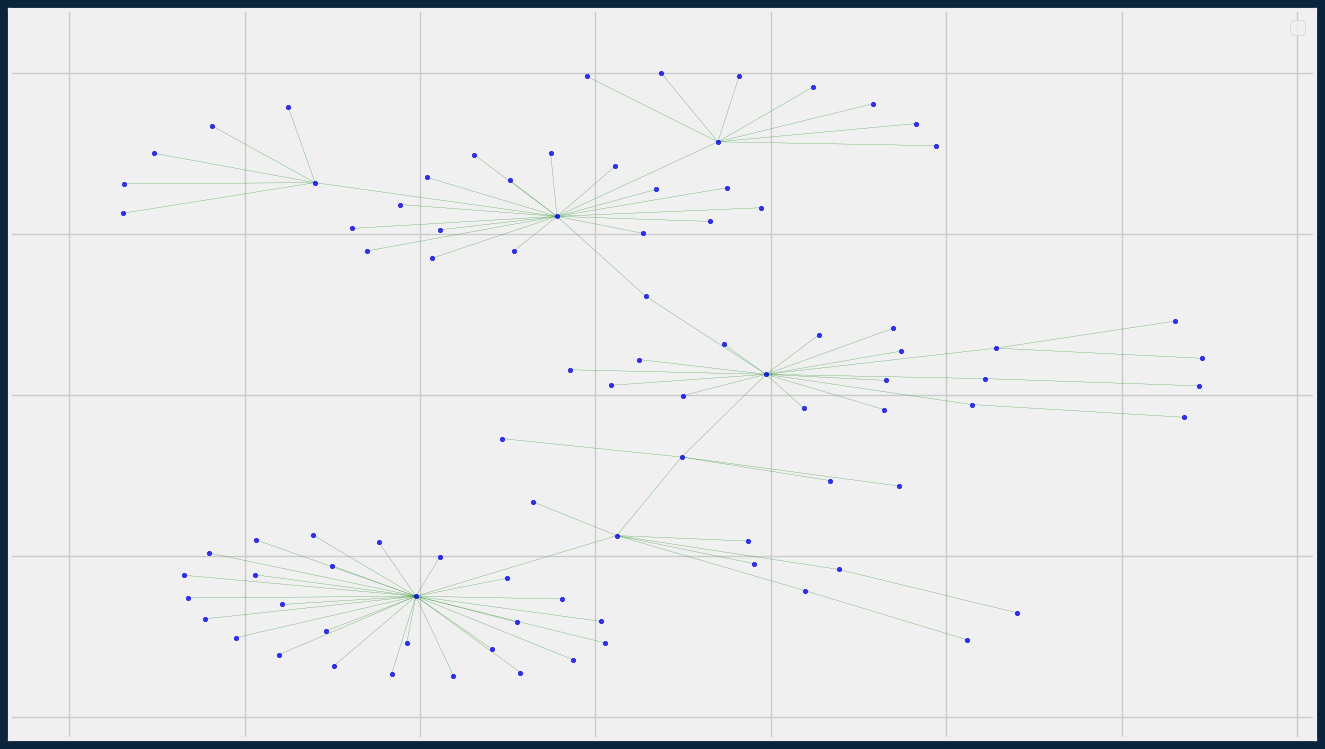

In [58]:
# Can I just look at how this is connecting the 2?

# Take a look at 3 degrees
# high_betweeness = '109447331150259202'
high_betweeness = '109831834621020128'
connector_nodes, connector_gph = get_graph_from_user(high_betweeness, 3)
draw_kamada(connector_gph)


/Users/cgopal/anaconda3/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


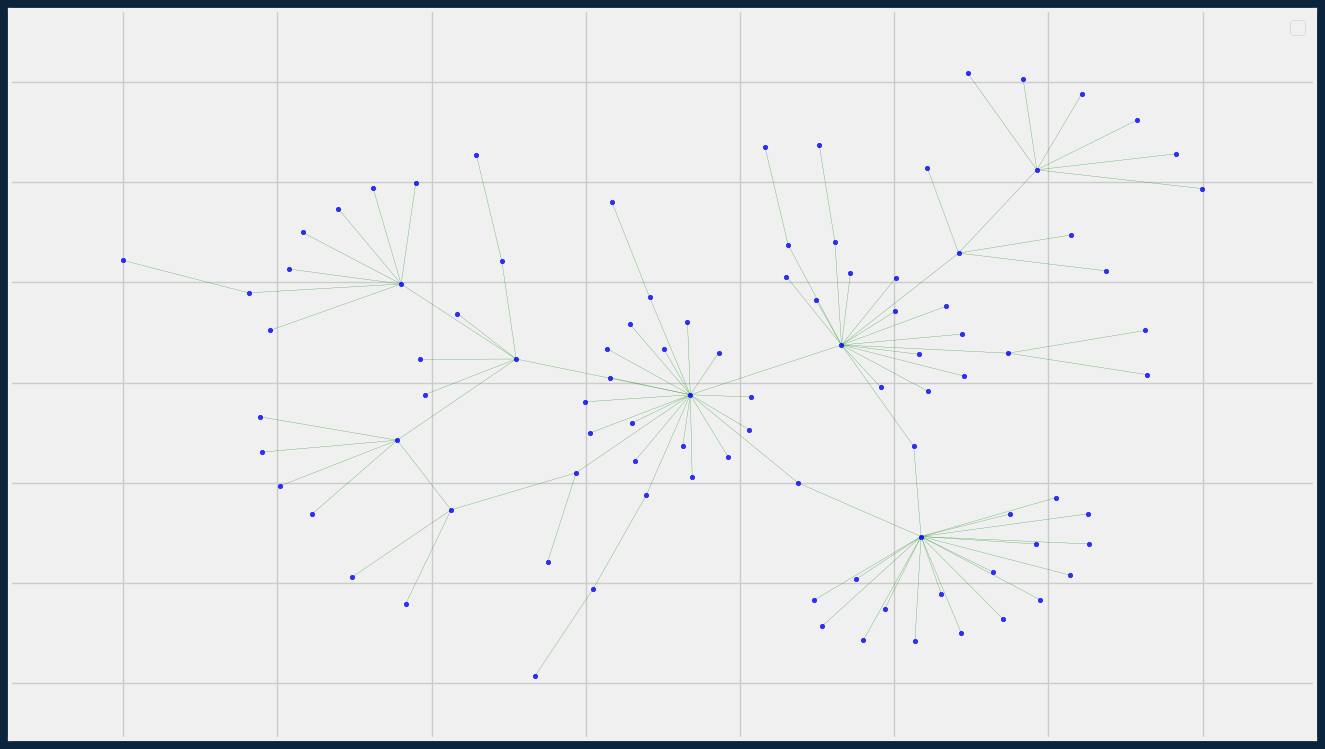

In [60]:
# Can I just look at how this is connecting the 2?

# Take a look at 3 degrees
# less_connector_nodes = statuses_df.loc[statuses_df['parent_account_id'] == "30437"]

# low_betweeness = '30437'
low_betweeness = '340290'
less_connector_nodes, less_connector_gph = get_graph_from_user(low_betweeness, 3)
draw_kamada(less_connector_gph)

In [63]:
# TBD we did 35K reply threads
# topics_threads = pd.read_parquet('{}/results/df_for_discovery_35k_full.parquet'.format(data_path))
topics_threads = pd.read_parquet('{}/results/df_for_discovery_35k_full.parquet'.format("../../data"))
print(len(topics_threads))

35717


In [64]:
topics_threads['topics_single'] = topics_threads['topics'].apply(lambda t: t[0] if len(t) > 0  else '')
merged_topics = connector_nodes.merge(topics_threads, left_on='id', right_on='id', how = 'inner')
display(merged_topics.describe())
display(merged_topics.head(10))


,replies_count_x,reblogs_count_x,favourites_count_x,created_at_ts_x,degree,replies_count_y,reblogs_count_y,favourites_count_y,created_at_ts_y
count,324.000000,324.000000,324.000000,3.240000e+02,324.000000,324.000000,324.000000,324.000000,3.240000e+02
mean,0.595679,0.197531,0.598765,1.685498e+09,3.262346,0.595679,0.197531,0.598765,1.685498e+09
std,1.278585,1.471460,2.627457,3.568584e+05,0.928897,1.278585,1.471460,2.627457,3.568584e+05
min,0.000000,0.000000,0.000000,1.685318e+09,1.000000,0.000000,0.000000,0.000000,1.685318e+09
25%,0.000000,0.000000,0.000000,1.685409e+09,3.000000,0.000000,0.000000,0.000000,1.685409e+09
50%,0.000000,0.000000,0.000000,1.685460e+09,4.000000,0.000000,0.000000,0.000000,1.685460e+09
75%,1.000000,0.000000,1.000000,1.685463e+09,4.000000,1.000000,0.000000,1.000000,1.685463e+09
max,8.000000,13.000000,31.000000,1.687589e+09,4.000000,8.000000,13.000000,31.000000,1.687589e+09


,id,created_at_x,in_reply_to_id_x,in_reply_to_account_id_x,sensitive_x,spoiler_text_x,visibility_x,language_x,uri_x,url_x,...,parent_account_id_y,application_y,user_id,note,display_name,username,content_cleaned,note_cleaned,topics,topics_single
0,110458315086813028,2023-05-30T15:21:44.000Z,110458292090269502,109831834621020128,True,cryptic crossword clue that made me yell out l...,public,en,https://posts.rat.pictures/users/hannah/status...,https://posts.rat.pictures/@hannah/11045831343...,...,109831834621020128,None,109831834621020128,"<p>small mammal, game show winner<br>she/her<b...",tv's hannah,hannah,seafood unlike bookcase tongue,small mammal game show winner sheher chicago p...,[food_&_dining],food_&_dining
1,110458315086813028,2023-05-30T15:21:44.000Z,110458292090269502,109831834621020128,True,cryptic crossword clue that made me yell out l...,public,en,https://posts.rat.pictures/users/hannah/status...,https://posts.rat.pictures/@hannah/11045831343...,...,109831834621020128,None,109831834621020128,"<p>small mammal, game show winner<br>she/her<b...",tv's hannah,hannah,seafood unlike bookcase tongue,small mammal game show winner sheher chicago p...,[food_&_dining],food_&_dining
2,110458315086813028,2023-05-30T15:21:44.000Z,110458292090269502,109831834621020128,True,cryptic crossword clue that made me yell out l...,public,en,https://posts.rat.pictures/users/hannah/status...,https://posts.rat.pictures/@hannah/11045831343...,...,109831834621020128,None,109831834621020128,"<p>small mammal, game show winner<br>she/her<b...",tv's hannah,hannah,seafood unlike bookcase tongue,small mammal game show winner sheher chicago p...,[food_&_dining],food_&_dining
3,110458315086813028,2023-05-30T15:21:44.000Z,110458292090269502,109831834621020128,True,cryptic crossword clue that made me yell out l...,public,en,https://posts.rat.pictures/users/hannah/status...,https://posts.rat.pictures/@hannah/11045831343...,...,109831834621020128,None,109831834621020128,"<p>small mammal, game show winner<br>she/her<b...",tv's hannah,hannah,seafood unlike bookcase tongue,small mammal game show winner sheher chicago p...,[food_&_dining],food_&_dining
4,110458325781695632,2023-05-30T15:24:01.000Z,110458315086813028,109831834621020128,False,,public,en,https://posts.rat.pictures/users/hannah/status...,https://posts.rat.pictures/@hannah/11045832237...,...,109831834621020128,None,109831834621020128,"<p>small mammal, game show winner<br>she/her<b...",tv's hannah,hannah,dont think society recognizes degree cryptic c...,small mammal game show winner sheher chicago p...,"[learning_&_educational, youth_&_student_life]",learning_&_educational
5,110458325781695632,2023-05-30T15:24:01.000Z,110458315086813028,109831834621020128,False,,public,en,https://posts.rat.pictures/users/hannah/status...,https://posts.rat.pictures/@hannah/11045832237...,...,109831834621020128,None,109831834621020128,"<p>small mammal, game show winner<br>she/her<b...",tv's hannah,hannah,dont think society recognizes degree cryptic c...,small mammal game show winner sheher chicago p...,"[learning_&_educational, youth_&_student_life]",learning_&_educational
6,110458325781695632,2023-05-30T15:24:01.000Z,110458315086813028,109831834621020128,False,,public,en,https://posts.rat.pictures/users/hannah/status...,https://posts.rat.pictures/@hannah/11045832237...,...,109831834621020128,None,109831834621020128,"<p>small mammal, game show winner<br>she/her<b...",tv's hannah,hannah,dont think society recognizes degree cryptic c...,small mammal game show winner sheher chicago p...,"[learning_&_educational, youth_&_student_life]",learning_&_educational
7,110458325781695632,2023-05-30T15:24:01.000Z,110458315086813028,109831834621020128,False,,public,en,https://posts.rat.pictures/users/hannah/status...,https://posts.rat.pictures/@hannah/11045832237...,...,109831834621020128,None,109831834621020128,"<p>small mammal, game show winner<br>she/her<b...",tv's hannah,hannah,dont think society recognizes degree cryptic c...,s

In [65]:
# NOTE: notes is from account.  Content is the main content and is stemmed/stopword removed
# Here's we can join centrality matrix and give the top eigenvector 


def get_topics_by_degree(_connector_nodes):
    merged_topics = _connector_nodes.merge(topics_threads, left_on='id', right_on='id', how = 'inner')
    merged_topics = merged_topics.loc[merged_topics['topics_single'] != ""]

    first_degree = merged_topics.loc[merged_topics['degree'] == 1]
    second_degree = merged_topics.loc[merged_topics['degree'] == 2]
    third_degree = merged_topics.loc[merged_topics['degree'] == 3]


    display(first_degree['topics_single'].value_counts())
    display(second_degree['topics_single'].value_counts())
    display(third_degree['topics_single'].value_counts())

# For the connector nodes above - just walk through each of the connections.  Do this by
# (1) Look for first degree connections - group by subjects

# get_topics_by_degree(connector_nodes)
get_topics_by_degree(less_connector_nodes)

diaries_&_daily_life     32
news_&_social_concern     2
film_tv_&_video           1
Name: topics_single, dtype: int64

diaries_&_daily_life       43
news_&_social_concern       4
film_tv_&_video             4
learning_&_educational      3
celebrity_&_pop_culture     1
music                       1
other_hobbies               1
travel_&_adventure          1
food_&_dining               1
Name: topics_single, dtype: int64

diaries_&_daily_life        48
news_&_social_concern       10
film_tv_&_video              8
celebrity_&_pop_culture      6
music                        3
learning_&_educational       3
business_&_entrepreneurs     2
arts_&_culture               2
other_hobbies                1
travel_&_adventure           1
food_&_dining                1
family                       1
fashion_&_style              1
sports                       1
Name: topics_single, dtype: int64